In [1]:
import numpy as np 
import pandas as pd 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("ggplot")
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_excel('/kaggle/input/basket-analysis/Basket Analysis - Data.xlsx')
data.head()

,Transaction Date,Customer ID,Product Description
0,2014-01-01,1249,citrus fruit
1,2014-01-01,1249,coffee
2,2014-01-01,1249,italian sausage
3,2014-01-01,1249,sausage
4,2014-01-01,1381,curd


In [3]:
data["Customer ID"].nunique(),data["Customer ID"].unique()

(3898, array([1249, 1381, 1440, ..., 4755, 1963, 4565]))

In [4]:
data["Product Description"].nunique()

170

In [5]:
ID=data["Customer ID"].unique()
ID.tolist()
ID.sort()

In [6]:
item=data.groupby('Customer ID')['Product Description'].apply(list)
items=[]
for i in range(3898):
    items.append(item.iloc[i])
basket=pd.DataFrame({"item":ID,"products":items})
basket['products'] = basket['products'].astype(str)
regex = r'[\[\]/,]'
basket['products'] = basket['products'].apply(lambda x: re.sub(regex, '', x))
basket.head(2)

,item,products
0,1000,'pastry' 'salty snack' 'small milk' 'med milk'...
1,1001,'rollsbuns' 'sausage' 'small milk' 'med milk' ...


In [7]:
#concatenate multi-word product names together
basket['products'] = basket['products'].apply(lambda x: re.sub(r'(\w+)\s(\w+)', r'\1_\2', x))
basket

,item,products
0,1000,'pastry' 'salty_snack' 'small_milk' 'med_milk'...
1,1001,'rollsbuns' 'sausage' 'small_milk' 'med_milk' ...
2,1002,'frozen_vegetables' 'other_vegetables' 'butter...
3,1003,'dental_care' 'frozen_meals' 'sauces' 'rollsbu...
4,1004,'med_milk' 'pip_fruit' 'tropical_fruit' 'cling...
...,...,...
3893,4996,'salty_snack' 'tropical_fruit' 'bottled_beer' ...
3894,4997,'canned_beer' 'italian_sausage' 'large_milk' '...
3895,4998,'curd' 'rollsbuns'
3896,4999,'herbs' 'newspapers' 'semi-finished_bread' 'de...


In [8]:
# Vectorize the data
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(basket['products'])

# Compute the similarity between products
products_similarities = cosine_similarity(tfidf_matrix.T)

# Compute the similarity between products using euclidean_distances
# from sklearn.metrics.pairwise import euclidean_distances
# products_similarities = euclidean_distances(svd_matrix)
# Define the number of clusters
n_clusters = 9

# Perform k-means clustering
km = KMeans(n_clusters=n_clusters,random_state=0)
km.fit(products_similarities)

# Print the products in each cluster
for i in range(n_clusters):
    indices = np.where(km.labels_ == i)[0]
    print("Cluster {}: {}".format(i+1, ', '.join(np.array(tfidf.get_feature_names())[indices].tolist())))
#     print("\n\n")

Cluster 1: artif, baby_cosmetics, bags, bathroom_cleaner, cocoa_drinks, cooking_chocolate, cookware, cream, frozen_chicken, frozen_fruits, hair_spray, honey, kitchen_utensil, make_up, nut_snack, organic_products, organic_sausage, potato_products, preservation_products, prosecco, pudding_powder, remover, rubbing_alcohol, skin_care, soap, specialty_vegetables, sweetener, tidbits, toilet_cleaner, whisky
Cluster 2: berries, beverages, butter_milk, candy, cat_food, cereals, chewing_gum, chocolate, coffee, cream_cheese, delete, dessert, detergent, frozen_meals, grapes, ham, hamburger_meat, hard_cheese, hygiene_articles, ice_cream, meat, misc, napkins, oil, onions, pasta, pickled_vegetables, products, redblush_wine, salty_snack, sliced_cheese, specialty_bar, specialty_chocolate, sugar, waffles, white_bread, white_wine
Cluster 3: abrasive_cleaner, baking_powder, brandy, cake_bar, candles, canned_fish, canned_fruit, canned_vegetables, chocolate_marshmallow, cleaner, cling_filmbags, condensed_mi

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(products_similarities, km.labels_)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 9 The average silhouette_score is : 0.08247222109636614


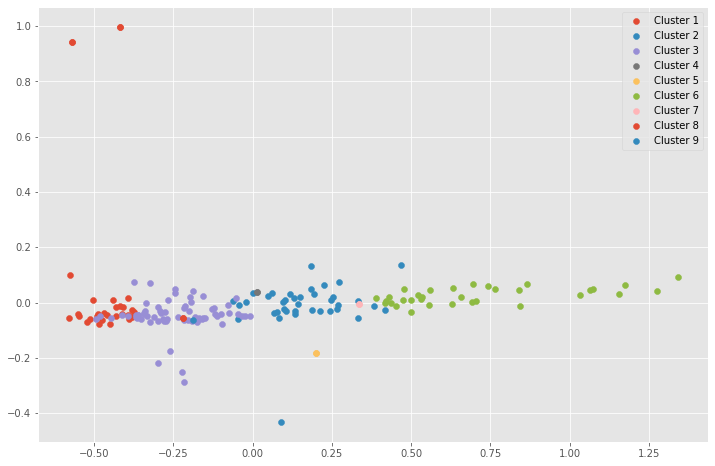

In [10]:
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(products_similarities)

# Plot the results
plt.figure(figsize=(12,8))
for i in range(n_clusters):
    indices = np.where(km.labels_ == i)[0]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Cluster {i+1}')
#     for j, product in enumerate(np.array(tfidf.get_feature_names())[indices.tolist()]):
#         plt.annotate(product, (pca_result[indices, 0][j], pca_result[indices, 1][j]))
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


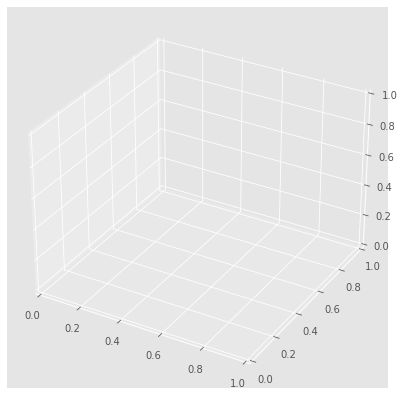

In [11]:
import plotly.colors
import plotly.graph_objs as go
# Reduce the dimensionality of the data to 2D
pca = PCA(n_components=3)
pca_result = pca.fit_transform(products_similarities)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')
offset = 0.1
data = []
for i in range(n_clusters):
    indices = np.where(km.labels_ == i)[0]
    trace = go.Scatter3d(x=pca_result[indices, 0], y=pca_result[indices, 1], z=pca_result[indices, 2], mode='markers',
    marker=dict(size=10, color=plotly.colors.DEFAULT_PLOTLY_COLORS[i]),
    text=[tfidf.get_feature_names()[i] for i in indices],
    name=f'Cluster {i+1}')
    data.append(trace)


layout = go.Layout(title='3D Plot',scene=dict(xaxis=dict(title='PC1'), yaxis=dict(title='PC2'), zaxis=dict(title='PC3')))
fig = go.Figure(data=data, layout=layout)
fig.show()

In [12]:
# Get the index of the products
products_index = tfidf.get_feature_names()

# Create an empty dataframe with 2 columns: 'Product' and 'Similar Products'
similar = pd.DataFrame(columns=['Product', 'Similar Products'])

# Iterate over each product
for i, product in enumerate(products_index):
    # Get the indices of the top 10 similar products
    top_10_similar_indices = np.argsort(-products_similarities[i])[:10]
    # Get the names of the top 10 similar products
    top_10_similar_products = [products_index[index] for index in top_10_similar_indices]
    # Add a new row to the dataframe with the product name and its top 10 similar products
    similar = similar.append({'Product': product, 'Similar Products': top_10_similar_products}, ignore_index=True)
similar

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Product,Similar Products
0,abrasive_cleaner,"[abrasive_cleaner, meat_spreads, med_milk, ket..."
1,appetizer,"[appetizer, liquor, soda, rollsbuns, other_veg..."
2,artif,"[artif, sweetener, baby_cosmetics, make_up, re..."
3,baby_cosmetics,"[baby_cosmetics, artif, sweetener, skin_care, ..."
4,bags,"[bags, liver_loaf, female_sanitary, instant_co..."
...,...,...
172,whisky,"[whisky, flour, frozen_potato, curd_cheese, bo..."
173,white_bread,"[white_bread, small_milk, rollsbuns, yogurt, o..."
174,white_wine,"[white_wine, small_milk, sausage, yogurt, othe..."
175,yogurt,"[yogurt, small_milk, other_vegetables, rollsbu..."


In [13]:
# # Vectorize the data
# tfidf = TfidfVectorizer()
# tfidf_matrix = tfidf.fit_transform(basket['products'])

# # Compute the similarity between products
# # products_similarities = cosine_similarity(tfidf_matrix.T)

# # Compute the similarity between products using euclidean_distances
# # from sklearn.metrics.pairwise import euclidean_distances
# # products_similarities = euclidean_distances(tfidf_matrix)

# # Define the number of clusters
# n_clusters = 9
# # Perform k-means clustering
# km = KMeans(n_clusters=n_clusters)
# km.fit(products_similarities)

# # Print the products in each cluster
# for i in range(n_clusters):
#     indices = np.where(km.labels_ == i)[0]
#     print("Cluster {}: {}".format(i+1, ', '.join(np.array(tfidf.get_feature_names_out())[indices].tolist())))
#     print("\n\n")

In [14]:
# tfidf = TfidfVectorizer()
# tfidf_matrix = tfidf.fit_transform(basket['products'])

# # Dimensionality reduction
# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=100)
# svd_matrix = svd.fit_transform(tfidf_matrix)

# # Compute the similarity between products using cosine_similarity
# products_similarities = cosine_similarity(svd_matrix)

# # # Compute the similarity between products using euclidean_distances
# # from sklearn.metrics.pairwise import euclidean_distances
# # products_similarities = euclidean_distances(svd_matrix)


# # Clustering
# from sklearn.cluster import AgglomerativeClustering
# n_clusters=7
# agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
# agg_clustering.fit(products_similarities)

# # Print the products in each cluster
# for i in np.unique(agg_clustering.labels_):
#     indices = np.where(agg_clustering.labels_ == i)[0]
#     print("Cluster {}: {}".format(i+1, ', '.join(np.array(tfidf.get_feature_names_out())[indices].tolist())))
#     print("\n\n\n")